Epoch 1/50


C:\Users\bibek\anaconda3\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor', 'keras_tensor_2', 'keras_tensor_6']. Received: the structure of inputs=('*', '*', '*')
  warnings.warn(


15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 110ms/step - accuracy: 0.3263 - loss: 1.6576 - val_accuracy: 0.4000 - val_loss: 1.2226
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.4065 - loss: 1.2440 - val_accuracy: 0.5833 - val_loss: 0.9638
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.5274 - loss: 1.0041 - val_accuracy: 0.6333 - val_loss: 0.8278
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.6912 - loss: 0.8081 - val_accuracy: 0.8667 - val_loss: 0.6307
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.8338 - loss: 0.6252 - val_accuracy: 0.8500 - val_loss: 0.5239
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8136 - loss: 0.4921 - val_accuracy: 0.8667 - val_loss: 0.4292
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8947 - loss: 0.3235 - val_accuracy: 0.9500 - val_loss: 0.3630
Epoch 8/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9658 - loss: 0.1911 - val_accuracy: 0.8833 - val_loss: 

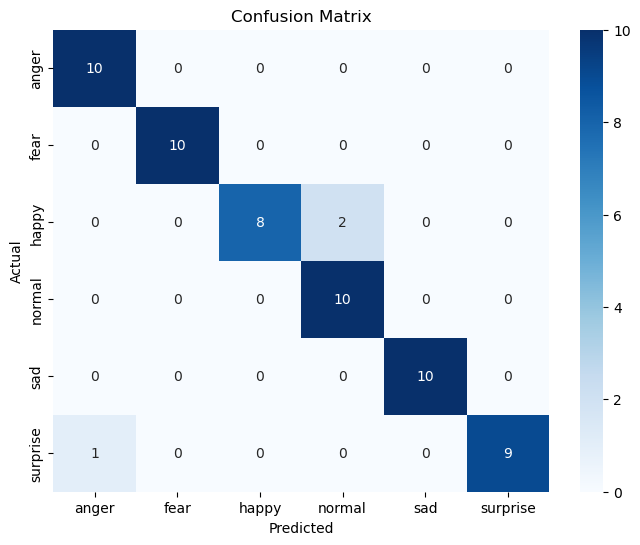

              precision    recall  f1-score   support

       anger       0.91      1.00      0.95        10
        fear       1.00      1.00      1.00        10
       happy       1.00      0.80      0.89        10
      normal       0.83      1.00      0.91        10
         sad       1.00      1.00      1.00        10
    surprise       1.00      0.90      0.95        10

    accuracy                           0.95        60
   macro avg       0.96      0.95      0.95        60
weighted avg       0.96      0.95      0.95        60



In [5]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Concatenate, Dropout, Flatten
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# 1️⃣ Load Extracted Features from Excel Files
path_thermal = "C:\\Users\\bibek\\Downloads\\PROJECT2\\thermalrefined.xlsx"
path_digital = "C:\\Users\\bibek\\Downloads\\PROJECT2\\digitfile_refined.xlsx"
path_eeg = "C:\\Users\\bibek\\Downloads\\PROJECT2\\EEGrefined.xlsx"

df_thermal = pd.read_excel(path_thermal)
df_digital = pd.read_excel(path_digital)
df_eeg = pd.read_excel(path_eeg)

# 2️⃣ Separate Labels and Features
y_labels = df_eeg.iloc[:, 0]  # Assuming first column is emotion labels
X_thermal = df_thermal.iloc[:, 1:].values  # Exclude label column
X_digital = df_digital.iloc[:, 1:].values  # Exclude label column
X_eeg = df_eeg.iloc[:, 1:].values  # Exclude label column

# 3️⃣ Encode Labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y_labels)  # Convert emotions to numbers

# 4️⃣ Convert Data Type
X_thermal = np.array(X_thermal, dtype=np.float32)
X_digital = np.array(X_digital, dtype=np.float32)
X_eeg = np.array(X_eeg, dtype=np.float32)
y = np.array(y, dtype=np.int32)

# 5️⃣ Normalize Features
scaler = StandardScaler()
X_thermal = scaler.fit_transform(X_thermal)
X_digital = scaler.fit_transform(X_digital)
X_eeg = scaler.fit_transform(X_eeg)

# 6️⃣ Reshape EEG Data for LSTM
X_eeg = X_eeg.reshape((X_eeg.shape[0], X_eeg.shape[1], 1))  # LSTM expects 3D input

# 7️⃣ Train-Test Split
X_train_eeg, X_test_eeg, X_train_digital, X_test_digital, X_train_thermal, X_test_thermal, y_train, y_test = train_test_split(
    X_eeg, X_digital, X_thermal, y, test_size=0.2, random_state=42, stratify=y
)

# 8️⃣ Define Deep Learning Model (LSTM + Dense Fusion)

# LSTM Model for EEG
input_eeg = Input(shape=(X_train_eeg.shape[1], 1))
lstm_layer = LSTM(64, return_sequences=False)(input_eeg)

# Fully Connected Model for Digital Features
input_digital = Input(shape=(X_train_digital.shape[1],))
x2 = Dense(128, activation="relu")(input_digital)
x2 = Dropout(0.3)(x2)
x2 = Dense(64, activation="relu")(x2)

# Fully Connected Model for Thermal Features
input_thermal = Input(shape=(X_train_thermal.shape[1],))
x3 = Dense(128, activation="relu")(input_thermal)
x3 = Dropout(0.3)(x3)
x3 = Dense(64, activation="relu")(x3)

# Fusion Layer
merged = Concatenate()([lstm_layer, x2, x3])
merged = Dense(128, activation="relu")(merged)
merged = Dropout(0.4)(merged)
merged = Dense(64, activation="relu")(merged)

# Output Layer
output = Dense(6, activation="softmax")(merged)  # 6 emotions classification

# Create Model
model = Model(inputs=[input_eeg, input_digital, input_thermal], outputs=output)
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# 9️⃣ Train Model
history = model.fit(
    [X_train_eeg, X_train_digital, X_train_thermal], y_train,
    validation_data=([X_test_eeg, X_test_digital, X_test_thermal], y_test),
    epochs=50, batch_size=16, verbose=1
)

# 🔟 Evaluate Model
test_loss, test_accuracy = model.evaluate([X_test_eeg, X_test_digital, X_test_thermal], y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# 🔹 Confusion Matrix
y_pred = np.argmax(model.predict([X_test_eeg, X_test_digital, X_test_thermal]), axis=1)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# 🔹 Classification Report
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))


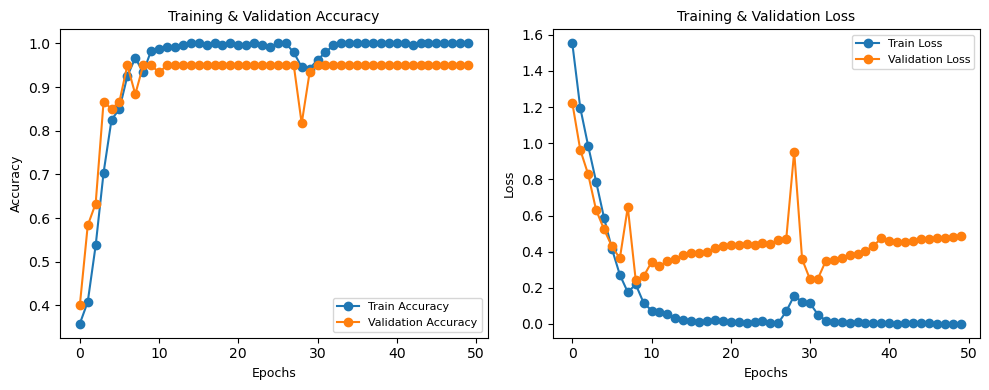

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


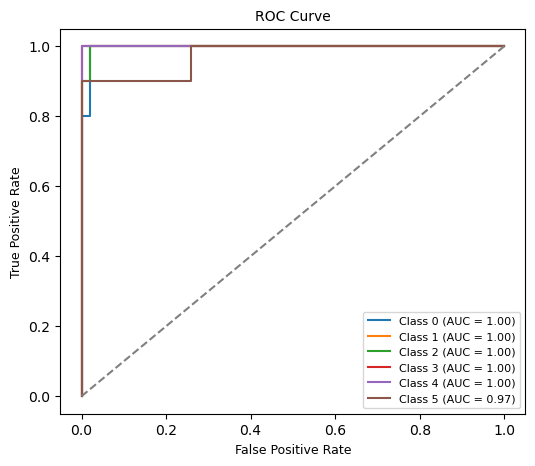

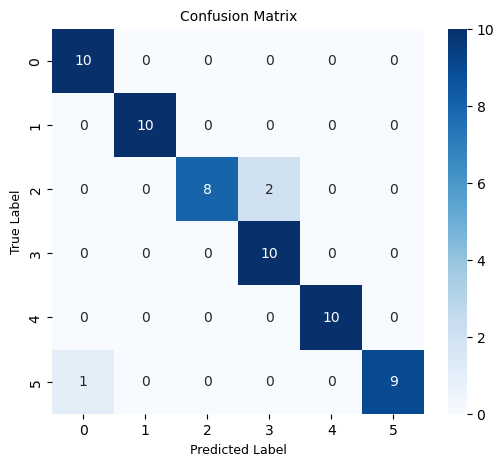

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import confusion_matrix, roc_curve, auc

# 🔹 Training & Validation Accuracy & Loss Graphs
plt.figure(figsize=(10, 4))  # Small figure size

# Training & Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title("Training & Validation Accuracy", fontsize=10)
plt.xlabel("Epochs", fontsize=9)
plt.ylabel("Accuracy", fontsize=9)
plt.legend(fontsize=8)

# Training & Validation Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title("Training & Validation Loss", fontsize=10)
plt.xlabel("Epochs", fontsize=9)
plt.ylabel("Loss", fontsize=9)
plt.legend(fontsize=8)

plt.tight_layout()
plt.show()

# 🔹 ROC Curve for Multiclass Classification
y_prob = model.predict([X_test_eeg, X_test_digital, X_test_thermal])  # Get predicted probabilities
y_test_bin = tf.keras.utils.to_categorical(y_test, num_classes=6)  # One-hot encode labels

plt.figure(figsize=(6, 5))  # Small figure size

for i in range(6):  
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob[:, i])  # Compute FPR & TPR
    roc_auc = auc(fpr, tpr)  # Compute AUC Score
    plt.plot(fpr, tpr, label=f"Class {i} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], linestyle="--", color="gray")  # Random classifier line
plt.xlabel("False Positive Rate", fontsize=9)
plt.ylabel("True Positive Rate", fontsize=9)
plt.title("ROC Curve", fontsize=10)
plt.legend(fontsize=8)
plt.show()

# 🔹 Confusion Matrix
y_pred_classes = np.argmax(y_prob, axis=1)  # Convert probabilities to class labels
cm = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(6, 5))  # Small figure size
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(6), yticklabels=range(6))

plt.xlabel("Predicted Label", fontsize=9)
plt.ylabel("True Label", fontsize=9)
plt.title("Confusion Matrix", fontsize=10)
plt.show()


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step 


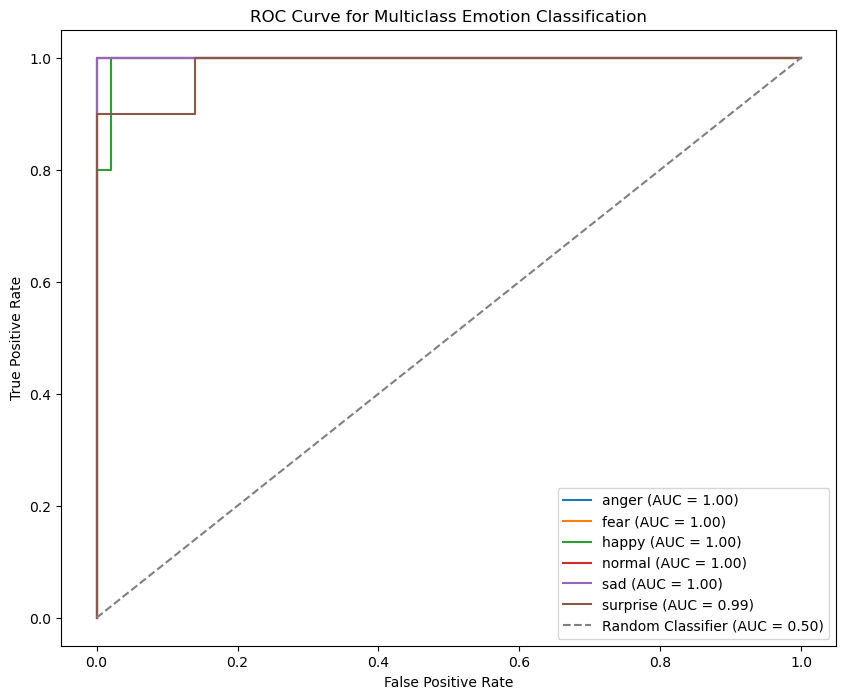

In [5]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# 🔹 Convert Labels to One-Hot Encoding
num_classes = 6  # We have 6 emotions
y_test_bin = tf.keras.utils.to_categorical(y_test, num_classes=num_classes)

# 🔹 Get Predicted Probabilities for Each Class
y_prob = model.predict([X_test_eeg, X_test_digital, X_test_thermal])

# 🔹 Plot ROC Curve for Each Emotion Class
plt.figure(figsize=(10, 8))

for i in range(num_classes):  
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob[:, i])  # Compute FPR & TPR for class i
    roc_auc = auc(fpr, tpr)  # Compute AUC Score
    plt.plot(fpr, tpr, label=f"{label_encoder.classes_[i]} (AUC = {roc_auc:.2f})")

# 🔹 Plot Random Classifier Line (Baseline)
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Classifier (AUC = 0.50)")

# 🔹 Labels & Title
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Multiclass Emotion Classification")
plt.legend()
plt.show()



In [3]:
# 🔹 ROC Curve for Multiclass Classification
y_prob = model.predict([X_test_eeg, X_test_digital, X_test_thermal])  # Get predicted probabilities
y_test_bin = tf.keras.utils.to_categorical(y_test, num_classes=6)  # One-hot encode labels

plt.figure(figsize=(6, 5))  # Reduce the figure size

for i in range(6):  
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob[:, i])  # Compute FPR & TPR
    roc_auc = auc(fpr, tpr)  # Compute AUC Score
    plt.plot(fpr, tpr, label=f"Class {label_encoder.classes_[i]} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], linestyle="--", color="gray")  # Random classifier line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


NameError: name 'model' is not defined